## Problem 1.1 and 1.2

### Import the relevant libraries

In [0]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

### Load the dataset

In [0]:
train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('data',
                      train=True,
                      download=True,
                      transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
      datasets.MNIST('data',
                      train=False,
                      download=True,
                      transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=128, shuffle=True)

In [8]:
# !ls data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
# load a batch of data
images, labels = next(iter(train_loader))
print(len(images))

128


In [10]:
# check shapes
# o/p format: batch_size, num_channels, height, width
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [11]:
# check the shape of 1 image
images[0].shape

torch.Size([1, 28, 28])

In [12]:
# we need to remove the channel dimension before we can plot it
# there are various ways to do so
images[0].view(28,28).shape

torch.Size([28, 28])

In [13]:
images[0].squeeze(0).shape

torch.Size([28, 28])

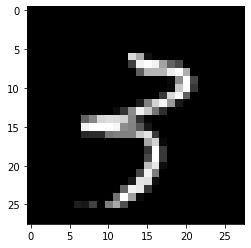

In [14]:
# reshape and plot the first image
plt.imshow(images[0].reshape(28,28), cmap="gray")

### Defining the model architecture

In [0]:
class Model(nn.Module):

  def __init__(self):
    super().__init__()

    n_hidden = 1024

    self.l1 = nn.Linear(784, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_hidden)
    self.l3 = nn.Linear(n_hidden, n_hidden)
    self.l4 = nn.Linear(n_hidden, n_hidden)
    self.l5 = nn.Linear(n_hidden, n_hidden)
    self.l6 = nn.Linear(n_hidden, n_hidden)
    self.l7 = nn.Linear(n_hidden, 10)

    self.dropout = nn.Dropout(0.2)
  
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.dropout(x)
    x = F.relu(self.l2(x))
    x = self.dropout(x)
    x = F.relu(self.l3(x))
    x = self.dropout(x)
    x = F.relu(self.l4(x))
    x = self.dropout(x)
    x = F.relu(self.l5(x))
    x = self.dropout(x)
    x = F.relu(self.l6(x))
    x = self.dropout(x)
    x = self.l7(x)

    return x

In [0]:
model = Model()

In [0]:
model = model.to(device)

In [18]:
print(model)

Model(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=1024, bias=True)
  (l4): Linear(in_features=1024, out_features=1024, bias=True)
  (l5): Linear(in_features=1024, out_features=1024, bias=True)
  (l6): Linear(in_features=1024, out_features=1024, bias=True)
  (l7): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Defining loss function and optimizer

In [0]:
# CrossEntropy does softmax internally hence we don't do it in our model
criterion = nn.CrossEntropyLoss()

In [20]:
images.shape[0]

128

In [0]:
# to pass our images to the nn, we need to unpack them (28*28 -> 784)
# keep the first dimension and unpack the other dimensions
images = images.view(images.shape[0], -1)

In [22]:
images.shape

torch.Size([128, 784])

In [0]:
images = images.to(device)
labels = labels.to(device)

In [24]:
# we can now use our model like a function
outputs = model(images)
outputs.shape

torch.Size([128, 10])

In [25]:
# and calculate the loss
loss = criterion(outputs, labels)
loss

tensor(2.3041, device='cuda:0', grad_fn=<NllLossBackward>)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [27]:
epochs = 20
for e in range(epochs):
    # loss for every epoch
    running_loss = 0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      images = images.view(images.shape[0], -1)

      # make the gradients 0 for a new batch
      optimizer.zero_grad()

      # calculate the outputs
      output = model(images)

      # calculate the loss
      loss = criterion(output, labels)

      # calculate the gradients
      loss.backward()

      # update the weights
      optimizer.step()
        
      running_loss += loss.item()

    print(f"Loss for epoch {e}: {running_loss/len(train_loader)}")

Loss for epoch 0: 0.3648101705541489
Loss for epoch 1: 0.16974399700713183
Loss for epoch 2: 0.13464154577307674
Loss for epoch 3: 0.11489667721203904
Loss for epoch 4: 0.10363576698230147
Loss for epoch 5: 0.09392603130530575
Loss for epoch 6: 0.08080888834239831
Loss for epoch 7: 0.07869376064633637
Loss for epoch 8: 0.07275524305334605
Loss for epoch 9: 0.07359319090096554
Loss for epoch 10: 0.06128684973229032
Loss for epoch 11: 0.06772146611881535
Loss for epoch 12: 0.06015108486037773
Loss for epoch 13: 0.06493409413264505
Loss for epoch 14: 0.05582391791172755
Loss for epoch 15: 0.04845634370104972
Loss for epoch 16: 0.05761508360060293
Loss for epoch 17: 0.05950156397728333
Loss for epoch 18: 0.04267619609304551
Loss for epoch 19: 0.0501422175406806


**Observations**:

I was initially using a batch size of 512 and I decreased it so that the weights would update more often. I was also using a learning rate of 0.09 which worked with SGD but not with Adam, hence I decreased it.

In [28]:
model.cpu()

Model(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=1024, bias=True)
  (l4): Linear(in_features=1024, out_features=1024, bias=True)
  (l5): Linear(in_features=1024, out_features=1024, bias=True)
  (l6): Linear(in_features=1024, out_features=1024, bias=True)
  (l7): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Calculate accuracy

In [0]:
preds = torch.Tensor()
actuals = torch.Tensor()
for images, labels in test_loader:
      images = images.view(images.shape[0], -1)
      preds = torch.cat((preds, model(images)))
      actuals = torch.cat((actuals, labels.float()))

In [30]:
preds.shape, actuals.shape

(torch.Size([10000, 10]), torch.Size([10000]))

In [0]:
preds = F.softmax(preds, dim=1)

In [32]:
preds[0].sum()

tensor(1., grad_fn=<SumBackward0>)

In [33]:
# take the max out of each row as pred
prob, pred = torch.max(preds, 1)
pred.shape

torch.Size([10000])

In [34]:
accuracy = (pred.float() == actuals).float().mean()
accuracy * 100

tensor(97.6800)

## Part 1.3 and 1.4

In [0]:
X_train = torch.Tensor()
y_train = torch.Tensor()
X_test = torch.Tensor()
y_test = torch.Tensor()

In [36]:
for images, labels in train_loader:
  images = images.view(images.shape[0], -1)
  X_train = torch.cat((X_train, images))
  y_train = torch.cat((y_train, labels.float()))

X_train.shape, y_train.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [37]:
for images, labels in test_loader:
  images = images.view(images.shape[0], -1)
  X_test = torch.cat((X_test, images))
  y_test = torch.cat((y_test, labels.float()))

X_test.shape, y_test.shape

(torch.Size([10000, 784]), torch.Size([10000]))

In [0]:
outputs = F.softmax(model(X_test[:1000]), dim=1)

In [39]:
outputs.shape

torch.Size([1000, 10])

In [0]:
best_images = []
best_labels = []
for i in range(outputs.shape[1]):
  # select a col
  col = outputs[:,i].detach().numpy()
  # create an array of indexes
  indexes = np.arange(1000)
  # sort the indexes in descending order and get the first 10
  sort_by = np.argsort(col)[::-1][:10]
  # store them
  for s in sort_by:
    best_images.append(X_test[s])
    best_labels.append(i)

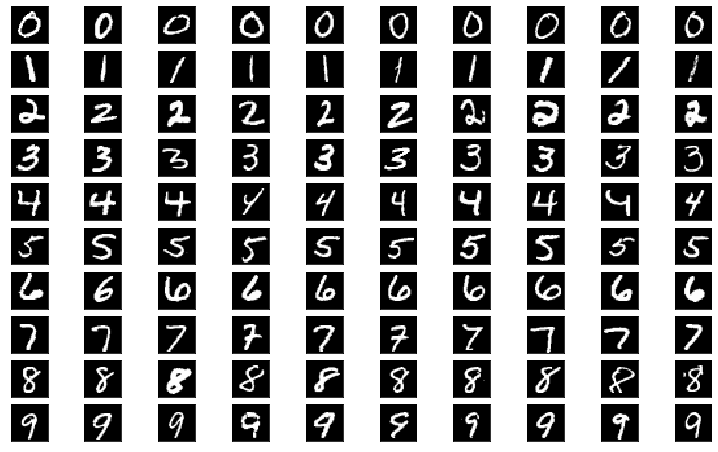

In [41]:
fig = plt.figure(figsize=(13, 8))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(best_images[idx].reshape(28,28)), cmap='gray')

In [42]:
layers = [module for module in model.modules() if type(module) == nn.Linear]
layers

[Linear(in_features=784, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=10, bias=True)]

In [43]:
layers = layers[:-1]
layers

[Linear(in_features=784, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True)]

In [0]:
def run_some_layers(x, num_layers):
  assert num_layers <= len(layers)
  for l in layers[:num_layers]:
    x = F.relu(l(x))
  return x

In [0]:
outputs = run_some_layers(X_test[:1000], len(layers))

In [46]:
outputs.shape

torch.Size([1000, 1024])

In [0]:
random_activations = list(np.random.randint(0,1024, 10))

In [48]:
outputs[:,random_activations].shape

torch.Size([1000, 10])

In [0]:
best_images = []
best_labels = []
for i in range(outputs.shape[1]):
  # select a col
  col = outputs[:,i].detach().numpy()
  # create an array of indexes
  indexes = np.arange(1000)
  # sort the indexes in descending order and get the first 10
  sort_by = np.argsort(col)[::-1][:10]
  # store them
  for s in sort_by:
    best_images.append(X_test[s])
    best_labels.append(i)

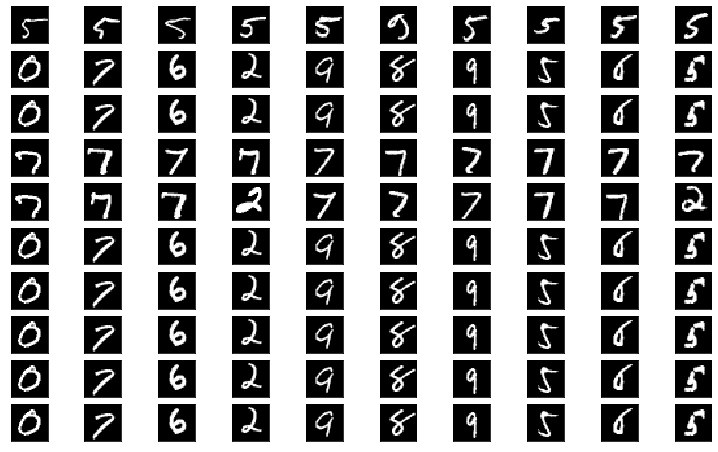

In [50]:
fig = plt.figure(figsize=(13, 8))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(best_images[idx].reshape(28,28)), cmap='gray')

## Part 1.5 to 1.8

In [0]:
X_train = torch.Tensor()
y_train = torch.Tensor()
X_test = torch.Tensor()
y_test = torch.Tensor()

In [52]:
for images, labels in train_loader:
  images = images.view(images.shape[0], -1)
  X_train = torch.cat((X_train, images))
  y_train = torch.cat((y_train, labels.float()))

X_train.shape, y_train.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [53]:
for images, labels in test_loader:
  images = images.view(images.shape[0], -1)
  X_test = torch.cat((X_test, images))
  y_test = torch.cat((y_test, labels.float()))

X_test.shape, y_test.shape

(torch.Size([10000, 784]), torch.Size([10000]))

#### PCA

In [0]:
pca = PCA(n_components=2)

In [0]:
red_features = pca.fit_transform(X_test[:1000])

In [56]:
red_features.shape

(1000, 2)

In [0]:
colors = y_test[:1000].numpy()

In [0]:
x = red_features[:,0]

In [0]:
y = red_features[:,1]

In [0]:
palette = sns.color_palette("Set2", 10)
title = 'PCA plot for input layer'

Text(0.5, 1.0, 'PCA plot for input layer')

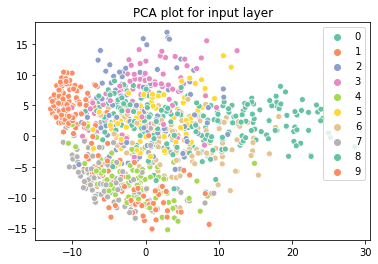

In [61]:
sns.scatterplot(x,y, hue=colors.astype(int), legend="full", palette = palette).set_title(title)

In [0]:
def plot_output(layer_num):
  output = run_some_layers(X_test[:1000], layer_num)
  red_features = pca.fit_transform(output.detach().numpy())
  x = red_features[:,0]
  y = red_features[:,1]
  title = f'PCA plot for {layer_num} layers'
  sns.scatterplot(x,y, hue=colors.astype(int), legend="full", palette = palette).set_title(title)


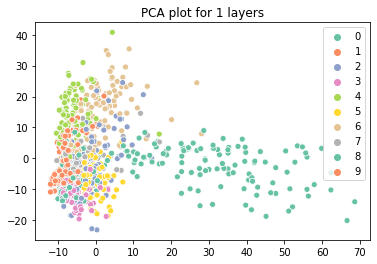

In [63]:
plot_output(1)

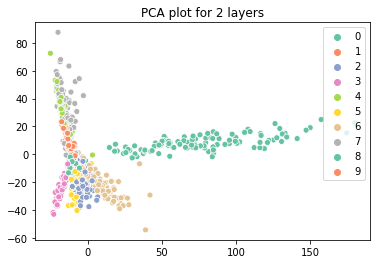

In [64]:
plot_output(2)

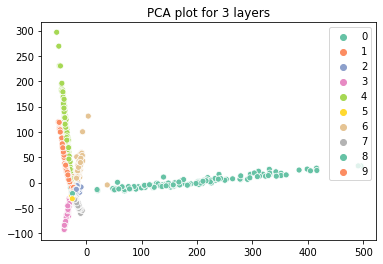

In [65]:
plot_output(3)

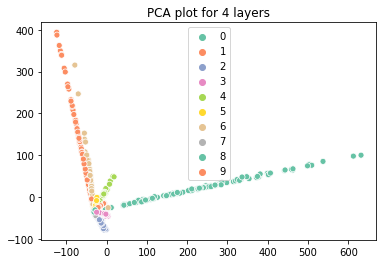

In [66]:
plot_output(4)

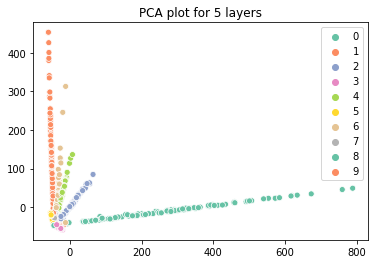

In [67]:
plot_output(5)

In [0]:
red_features = pca.fit_transform(model(X_test[:1000]).detach())

In [69]:
red_features.shape

(1000, 2)

Text(0.5, 1.0, 'PCA plot for model output')

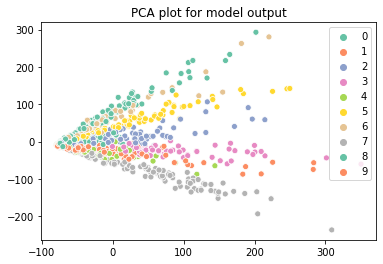

In [70]:
x = red_features[:,0]
y = red_features[:,1]
title = f'PCA plot for model output'
sns.scatterplot(x,y, hue=colors.astype(int), legend="full", palette = palette).set_title(title)

#### tSNE

In [0]:
tsne = TSNE(n_components=2)

In [0]:
red_features = tsne.fit_transform(X_test[:1000])

In [0]:
def tsne_plot_output(layer_num):
  output = run_some_layers(X_test[:1000], layer_num)
  red_features = tsne.fit_transform(output.detach().numpy())
  x = red_features[:,0]
  y = red_features[:,1]
  title = f'TSNE plot for {layer_num} layers'
  sns.scatterplot(x,y, hue=colors.astype(int), legend="full", palette = palette).set_title(title)

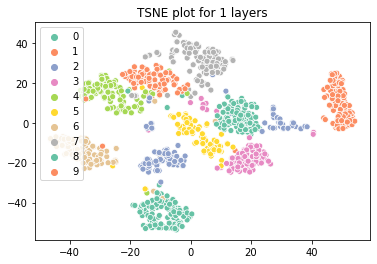

In [74]:
tsne_plot_output(1)

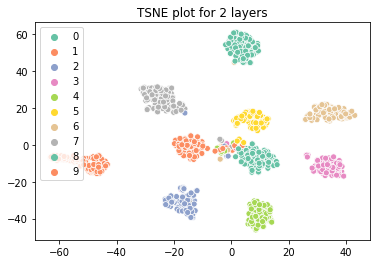

In [75]:
tsne_plot_output(2)

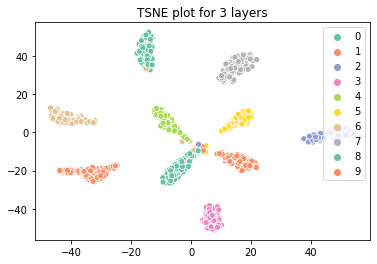

In [76]:
tsne_plot_output(3)

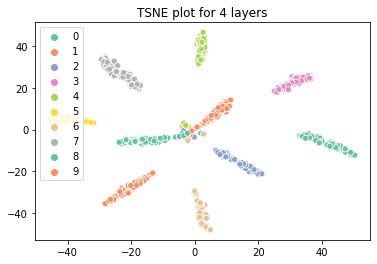

In [77]:
tsne_plot_output(4)

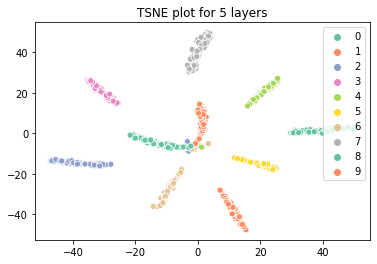

In [78]:
tsne_plot_output(5)

In [0]:
red_features = tsne.fit_transform(model(X_test[:1000]).detach())

Text(0.5, 1.0, 'TSNE plot for model output')

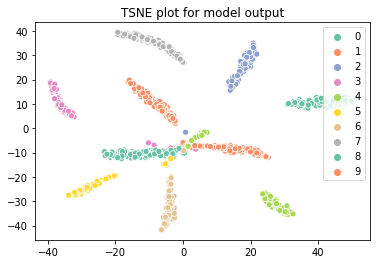

In [80]:
x = red_features[:,0]
y = red_features[:,1]
title = f'TSNE plot for model output'
sns.scatterplot(x,y, hue=colors.astype(int), legend="full", palette = palette).set_title(title)

**Observations**

We see that as we go ahead in the network, our data gets cast into a high dimensional space where the classes are separate